# Water impact 

The water footprint is an indicator of direct and indirect appropriation of freshwater resources. This term includes both consumptive water use (the blue and green water footprint) and the water required to assimilate pollution (grey water footprint).

Advanced frameworks consider both water performance in the direct operation as well as the indirect water footprint in order to fully understand how a certain business relates to water use efficiency and the exposure to risk.

The indicator provides incentives to improve water use efficiency through all sectors, highlighting those sectors where water use efficiency is lagging behind. 

We derive the total amount of annual, crop-specific water use from the blue water requirements of the Water Footprint Network (WFN) data layer. All calculations are performed on the grid-cell level  which comes in a resolution 5 minutes by 5 minutes (~10 km by 10 km).

Water impact  (m3 / year ) = (water footprint (m3/year) / All crops production (tons)) * (Harvested area (ha) / Total Harvested area (ha)) * Volume (tons) 

Datasets:

- Global water footprint by crop (1996 -2005) from Water Footprint which is splited by:
    - Blue Footprint by crop
    - Green Footprint by crop
    - Grey Footprint by crop
    - Total Footprint by crop
    
    Link to dataset: https://waterfootprint.org/media/downloads/Report47-App-IV-CropWaterFootprints-RasterMaps.zip
    
    
- Harvested area and production for 42 crops [MAPSPAM](https://www.mapspam.info/data/)

The water impact is calculated for each commodity following the formula below (which is also presented in this [doc](https://docs.google.com/document/d/1IDuYWOllQ2fTf2ZeBUmOtEZpqht2rqMot3G9W3CjEjE/edit#)): 

        Water impact  (m3 / year ) = (water footprint (m3/year) / All crops production (tons)) * (Harvested area (ha) / Total Harvested area (ha)) * Volume (tons) 
        


# Table of Contents
- # [Setup](#setup)
    - ## [Library import](#import)
    - ## [Utils](#utils)
- # [Data import](#data)
    - ## [Vector data ](#vector)
        - ### [India](#india)
    - ## [Raster data](#raster)
        - #### [Water footprint](#footprint)
        - #### [All crops production](#crops)
        - #### [Irrigated cotto production](#production)
        - #### [Irrigated cotto harvested area](#harvested)
    - ## [Merge datasets](#merge) 
- # [Compute water impact](#impact)

<a id='setup'></a>
# Setup

<a id='import'></a>
## Library import

In [31]:
import os
import xarray as xr
import rioxarray as rxr
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors

<a id='utils'></a>
## Utils

In [32]:
def da_plot(da, gdf, color_list, values, title, x='x', y='y', xlim=(65,100), ylim=(4,40)):
    # Define the colors you want
    cmap = ListedColormap(color_list)

    # Define a normalization from values -> colors
    norm = colors.BoundaryNorm(values, len(color_list))

    plt.figure(figsize=(12,10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    ax.set_global()

    gdf.plot(ax=ax, color='red', alpha=0.1, edgecolor='red')
    da.plot(ax=ax, norm=norm, cmap=cmap, x=x, y=y, transform=ccrs.PlateCarree())
    gdf.plot(ax=ax, color='w', alpha=0.1, edgecolor='red')
    ax.coastlines()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title)

<a id='data'></a>
# Data import

<a id='vector'></a>
## Vector data 

<a id='india'></a>
### India

In [33]:
#import geometry:
geom = gpd.read_file('../../datasets/raw/water/QA/gadm36_IND_0.shp')
geom.head()

,GID_0,NAME_0,geometry
0,IND,India,"MULTIPOLYGON (((93.78773 6.85264, 93.78849 6.8..."


<a id='raster'></a>
## Raster data

<a id='footprint'></a>
#### Water footprint

In [34]:
xda = rxr.open_rasterio('../../datasets/raw/water/QA/bl_wf_mmyr_area.tif').squeeze().drop("band")
# convert to Dataset 
xds_wf = xr.Dataset({'water_footprint': xda}, attrs=xda.attrs)
xds_wf

<xarray.Dataset>
Dimensions:          (x: 4320, y: 1668)
Coordinates:
  * x                (x) float64 -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
  * y                (y) float64 83.05 82.96 82.88 82.8 ... -55.7 -55.79 -55.87
    spatial_ref      int64 0
Data variables:
    water_footprint  (y, x) float32 ...
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

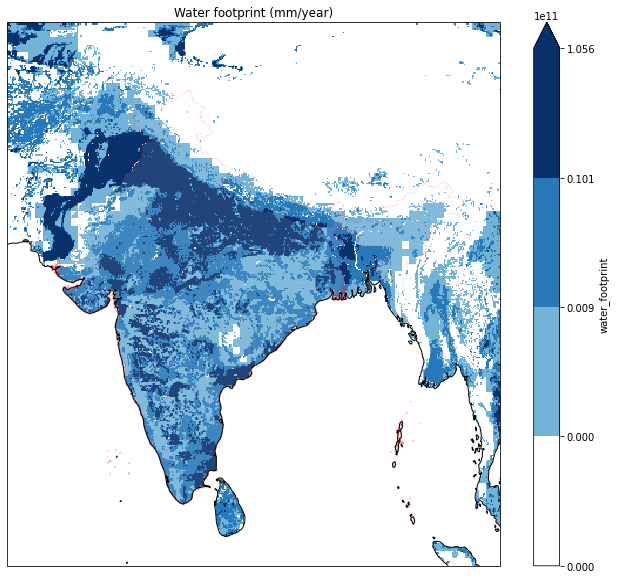

In [35]:
color_list = ["#ffffff", "#73b3d8", "#2879b9", "#08306b"]
values = [0, 29584100, 863202440, 10063202440,  105581714153]
title = 'Water footprint (mm/year)'

da_plot(xds_wf['water_footprint'], geom, color_list, values, title, x='x', y='y', xlim=(65,100), ylim=(4,40))

<a id='crops'></a>
### All crop production by technologies
- All: all technologies together
- Irrigated: irrigated portion of crop
- Rainfed: rainfed portion of crop

In [36]:
# Define path
path = '../../datasets/raw/spam2010v2r0_global_prod/'

In [37]:
tech_dict = {'All': 'A', 'Irrigated': 'I',  'Rainfed': 'R'}

for i, tech in enumerate(tech_dict.keys()):
    included_extensions = [f'{tech_dict[tech]}.tif']
    file_names = [fn for fn in os.listdir(path) if any(fn.endswith(ext) for ext in included_extensions)]

    for j, file in enumerate(file_names):
        xda = rxr.open_rasterio(path+file).squeeze().drop("band")

        # Remove negative values
        xda = xda.where(xda > 0)

        # Add crop coordinates
        crop_name = file.split('_')[-2]
        xda = xda.assign_coords({"crop": crop_name}).expand_dims(['crop']) 

        # Convert to Dataset 
        xds_tmp = xr.Dataset({tech: xda}, attrs=xda.attrs)

        if j == 0:
            xds_tech = xds_tmp 
        else:
            xds_tech = xr.concat([xds_tech, xds_tmp], dim='crop')

    if i == 0:
        xds_crop = xds_tech
    else:
        xds_crop = xr.merge([xds_crop, xds_tech])

In [38]:
xds_crop

<xarray.Dataset>
Dimensions:      (crop: 42, x: 4320, y: 2160)
Coordinates:
  * crop         (crop) <U4 'ACOF' 'BANA' 'BARL' 'BEAN' ... 'VEGE' 'WHEA' 'YAMS'
  * x            (x) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * y            (y) float64 89.96 89.88 89.79 89.71 ... -89.79 -89.87 -89.96
    spatial_ref  int64 0
Data variables:
    All          (crop, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    Irrigated    (crop, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    Rainfed      (crop, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    _FillValue:    -1.0
    scale_factor:  1.0
    add_offset:    0.0

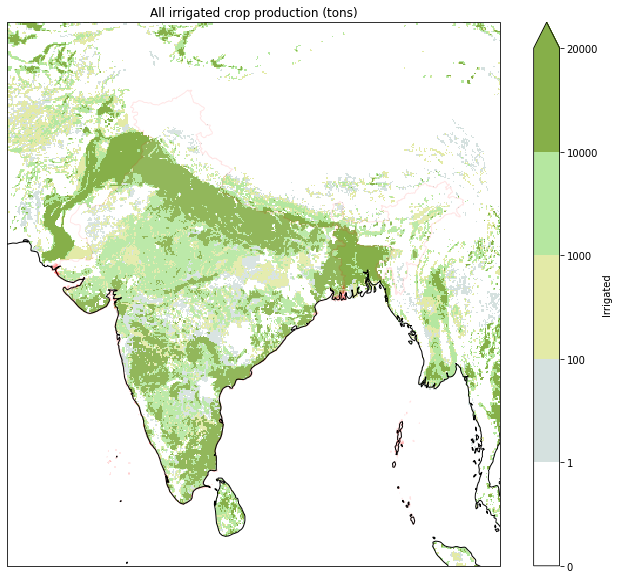

In [39]:
color_list = ["#ffffff", "#d5e1df", "#e3eaa7", "#b5e7a0", "#86af49"]
values = [0, 1, 100, 1000, 10000, 20000]
title = 'All irrigated crop production (tons)'

da_plot(xds_crop.sum('crop')['Irrigated'], geom, color_list, values, title, x='x', y='y', xlim=(65,100), ylim=(4,40))

<a id='production'></a>
#### Irrigated cotto production

In [40]:
xda = rxr.open_rasterio(path+'spam2010V2r0_global_P_COTT_I.tif').squeeze().drop("band")

# Remove negative values
xda = xda.where(xda > 0)

# Convert to Dataset 
xds_cp = xr.Dataset({'cotton_production': xda}, attrs=xda.attrs)
xds_cp

<xarray.Dataset>
Dimensions:            (x: 4320, y: 2160)
Coordinates:
  * x                  (x) float64 -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
  * y                  (y) float64 89.96 89.88 89.79 ... -89.79 -89.87 -89.96
    spatial_ref        int64 0
Data variables:
    cotton_production  (y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    _FillValue:    -1.0
    scale_factor:  1.0
    add_offset:    0.0

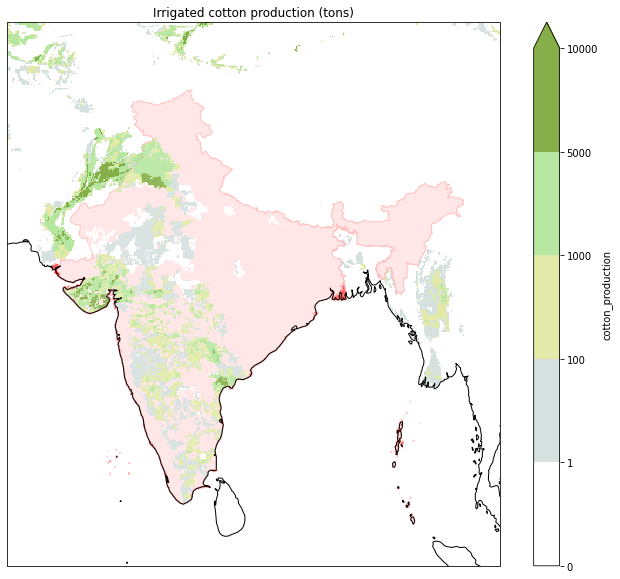

In [41]:
color_list = ["#ffffff", "#d5e1df", "#e3eaa7", "#b5e7a0", "#86af49"]
values = [0, 1, 100, 1000, 5000, 10000]
title = 'Irrigated cotton production (tons)'

da_plot(xds_cp['cotton_production'], geom, color_list, values, title, x='x', y='y', xlim=(65,100), ylim=(4,40))

**Total production of cotton**

In [42]:
tot_pro = xds_cp['cotton_production'].sum().data
print(f'Total production of cotton: {tot_pro} tonnes')

Total production of cotton: 43693792.0 tonnes


<a id='harvested'></a>
#### Irrigated cotto harvested area

In [43]:
xda = rxr.open_rasterio('../../datasets/raw/spam2010v2r0_global_harv_area/spam2010V2r0_global_H_COTT_I.tif').squeeze().drop("band")

# Remove negative values
xda = xda.where(xda > 0)

# Convert to Dataset 
xds_cha = xr.Dataset({'cotton_harvested_area': xda}, attrs=xda.attrs)
xds_cha

<xarray.Dataset>
Dimensions:                (x: 4320, y: 2160)
Coordinates:
  * x                      (x) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * y                      (y) float64 89.96 89.88 89.79 ... -89.87 -89.96
    spatial_ref            int64 0
Data variables:
    cotton_harvested_area  (y, x) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    _FillValue:    -1.0
    scale_factor:  1.0
    add_offset:    0.0

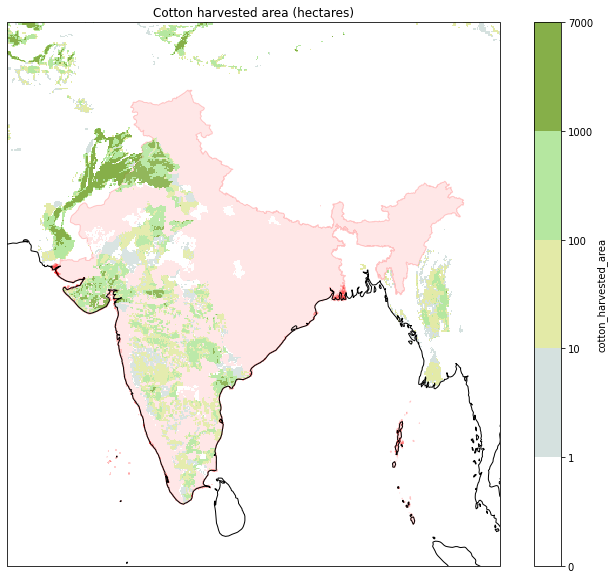

In [44]:
color_list = ["#ffffff", "#d5e1df", "#e3eaa7", "#b5e7a0", "#86af49"]
values = [0, 1, 10, 100, 1000, 7000]
title = 'Cotton harvested area (hectares)'

da_plot(xds_cha['cotton_harvested_area'], geom, color_list, values, title, x='x', y='y', xlim=(65,100), ylim=(4,40))

<a id='merge'></a>
## Merge datasets 
**Equal extents and coordinates**

In [45]:
print("MAPSPAM bbox: ", xds_cha.rio.bounds())

MAPSPAM bbox:  (-180.0, -89.99928000000003, 179.99856, 90.0)


In [46]:
!gdal_translate -projwin -180.0 90.0 179.99856 -89.99928000000003 -of GTiff $"../../datasets/raw/water/QA/bl_wf_mmyr_area.tif" $"../../datasets/raw/water/QA/bl_wf_mmyr_area_MAPSPAM_ext.tif"

Input file size is 4320, 1668
Warning 1: Computed -srcwin -1 -83 4320 2160 falls partially outside raster extent. Going on however.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [47]:
xda = rxr.open_rasterio('../../datasets/raw/water/QA/bl_wf_mmyr_area_MAPSPAM_ext.tif').squeeze().drop("band")
# Convert to Dataset 
xds_wf = xr.Dataset({'water_footprint': xda}, attrs=xda.attrs)

# Assign MAPSPAM coords
xds_wf = xds_wf.assign_coords(x=xds_cha.x.values)
xds_wf = xds_wf.assign_coords(y=xds_cha.y.values)

xds = xds_wf.copy()

# Add all variables
xds['all_crop_production'] = xds_crop.sum('crop')['Irrigated']
xds['cotton_production'] = xds_cp['cotton_production']
xds['cotton_harvested_area'] = xds_cha['cotton_harvested_area']

xds

<xarray.Dataset>
Dimensions:                (x: 4320, y: 2160)
Coordinates:
  * x                      (x) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * y                      (y) float64 89.96 89.88 89.79 ... -89.87 -89.96
    spatial_ref            int64 0
Data variables:
    water_footprint        (y, x) float32 ...
    all_crop_production    (y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cotton_production      (y, x) float32 nan nan nan nan ... nan nan nan nan
    cotton_harvested_area  (y, x) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

<a id='impact'></a>
# Compute water impact

Water impact  (m3/year) = (water footprint (m3/year) / All crops production (tons)) * (Harvested area (ha) / Total Harvested area (ha)) * Volume (tons) 

In [48]:
mm_to_m3 = 0.001
volume = 745


**Clip dataset with India**

In [49]:
xds_ind = xds.rio.clip(geom.geometry, geom.crs, drop=False, invert=False)
xds_ind["all_crop_production"] = xds_ind["all_crop_production"].where(xds_ind["all_crop_production"] > 0)
xds_ind['cotton_production'] = xds_ind['cotton_production'].where(xds_ind['cotton_production'] > 0)
xds_ind['cotton_harvested_area'] = xds_ind['cotton_harvested_area'].where(xds_ind['cotton_harvested_area'] > 0)
xds_ind

<xarray.Dataset>
Dimensions:                (y: 2160, x: 4320)
Coordinates:
  * y                      (y) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * x                      (x) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
    spatial_ref            int64 0
Data variables:
    water_footprint        (y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    all_crop_production    (y, x) float32 nan nan nan nan ... nan nan nan nan
    cotton_production      (y, x) float32 nan nan nan nan ... nan nan nan nan
    cotton_harvested_area  (y, x) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

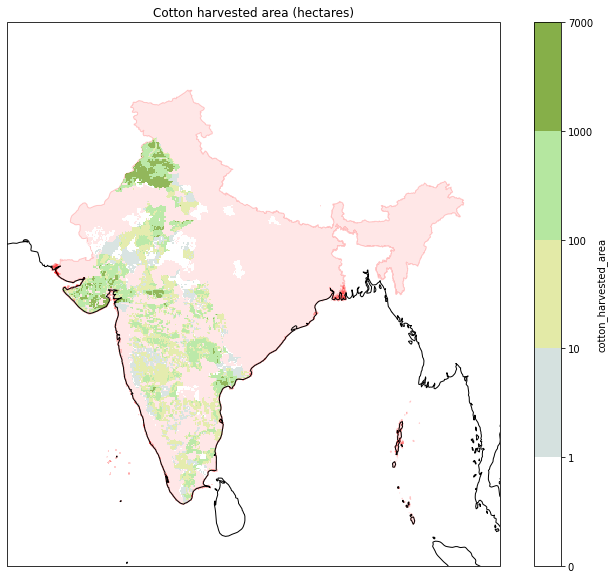

In [50]:
color_list = ["#ffffff", "#d5e1df", "#e3eaa7", "#b5e7a0", "#86af49"]
values = [0, 1, 10, 100, 1000, 7000]
title = 'Cotton harvested area (hectares)'

da_plot(xds_ind['cotton_harvested_area'], geom, color_list, values, title, x='x', y='y', xlim=(65,100), ylim=(4,40))

**Total production of cotton in India**

In [51]:
tot_pro = xds_ind["cotton_production"].sum().data
print(f'Total production of cotton in India: {tot_pro} tons')

Total production of cotton in India: 8992966.0 tons


**Total harvest area of cotton in India**

In [52]:
tot_ha = xds_ind["cotton_harvested_area"].sum().data
print(f'Total harvest area of cotton in India: {tot_ha} hectares')

Total harvest area of cotton in India: 3055540.5 hectares


### **Evenly distributed volume**

If the volume is distributed evenly across the entire area

Water impact (m3/year) = (water footprint (m3/year) / All crops production (tons)) * Volume(tons) 

In [53]:
mean_risk = ((xds_ind["water_footprint"]*mm_to_m3)/xds_ind["all_crop_production"]).mean().data
print(f'Total water impact for cotton in India:: {mean_risk * volume} m3/yr')

Total water impact for cotton in India:: 26278492.67578125 m3/yr


### **Probability purchase area**

The volume is distributed using the 'probabilistics purchase area' approach:

Probability purchase area (tons)  = (Volume(tons) / Total harvest area(ha)) * Harvest area(ha)

In [54]:
xds_ind = xds_ind.assign(probability_purchase_area = (volume/tot_ha)* xds_ind["cotton_harvested_area"])

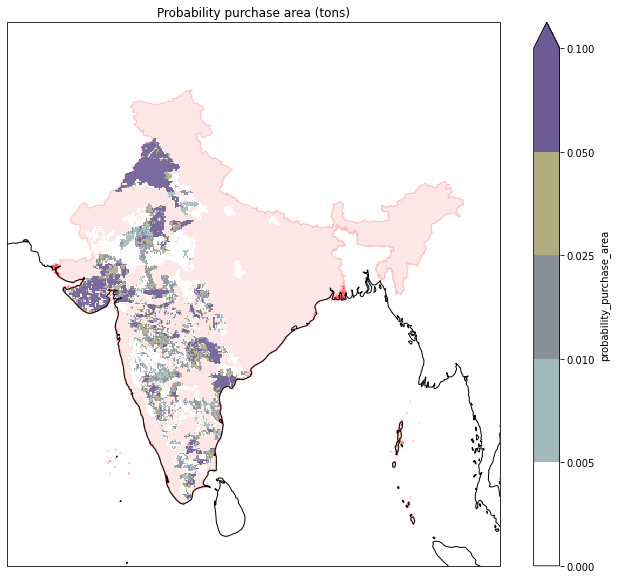

In [55]:
color_list = ["#ffffff", "#a2b9bc", "#878f99", "#b2ad7f", "#6b5b95"]
values = [0, 0.005, 0.01, 0.025, 0.05, 0.1]
title = 'Probability purchase area (tons)'
da_plot(xds_ind['probability_purchase_area'], geom, color_list, values, title, x='x', y='y', xlim=(65,100), ylim=(4,40))

Check that the volume distributed is equal to the volume injested by the user.

In [56]:
tot_volume = xds_ind["probability_purchase_area"].sum().data
print(f'Total distrivuted volume of cottom in India: {tot_volume} tons')

Total distrivuted volume of cottom in India: 745.0000610351562 tons


**Water impact**

Water impact (m3/year) = (water footprint (m3/year) / All crops production (tons)) * Probability purchase area (tons)

In [57]:
xds_ind = xds_ind.assign(water_impact = ((xds_ind["water_footprint"]*mm_to_m3)/xds_ind["all_crop_production"]) * xds_ind['probability_purchase_area'])

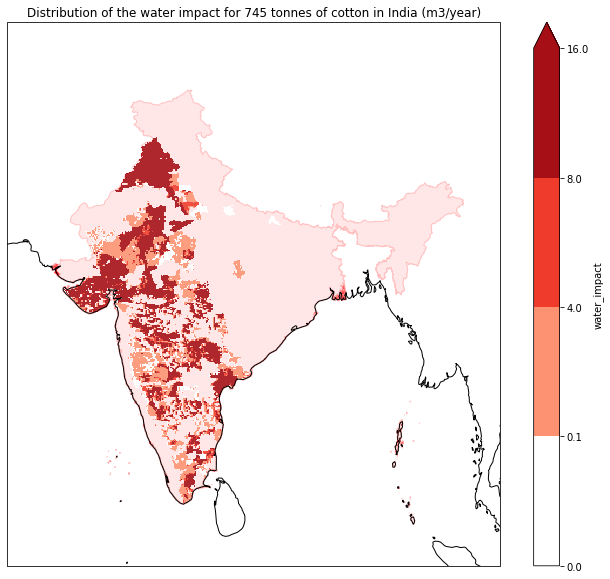

In [58]:
color_list = ["#ffffff", "#fc9272", "#ef3b2c", "#a50f15"]
values = [0, 0.1, 4, 8,  16]

title = 'Distribution of the water impact for 745 tonnes of cotton in India (m3/year)'

da_plot(xds_ind['water_impact'],geom, color_list, values, title, x='x', y='y', xlim=(65,100), ylim=(4,40))

**Total impact for 745 tonnes of cotton in india**

In [59]:
tot_impact = xds_ind['water_impact'].sum().data
print(f'Total water impact for 745 tonnes of cotton in India:: {tot_impact} m3/yr')

Total water impact for 745 tonnes of cotton in India:: 1019260.6875 m3/yr


**Total impact of all produced cotton in india**

In [60]:
tot_impact_all = (((xds_ind["water_footprint"]*mm_to_m3)/xds_ind["all_crop_production"]) * (xds_ind["cotton_harvested_area"]/tot_ha) * tot_pro).sum().data
print(f'Total water impact for cotton in India:: {tot_impact_all} m3/yr')

Total water impact for cotton in India:: 12303593472.0 m3/yr


### **Validation**

In order to validate our analysis we compare our results with the values shown in  Table 3.4 of [this report](https://www.waterfootprint.org/media/downloads/Report18.pdf).

According to this report the volume of the blue water use for cotton in India is 11.9 Gm3/yr, which is of the same order of magnitude as the value that we get here: 12.3 Gm3/yr.

In addition the virtual blue water content is 2150 (m3/yr ton), so the impact for 745 tonnes of cotton in India is equal to 1.6 Mm3/yr, which is again of the same order of magnitude as the value that we get here: 1.0 Mm3/yr. 